In [1]:
from main import Simulation
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

from ipywidgets import interactive

%matplotlib inline

In [2]:
plt.rcParams["font.size"] = 18
plt.rcParams["figure.facecolor"] = "white"

ESZTER - I've added a `config` dict parameter input to the constructors both the Simulation and DataLoader classes. This way, we can control from here which file to load, or we could later add multiple parameters from the "outside" of the code.

In [15]:
sim_1 = Simulation(contact_data_file="dynmatrix_step_1d_window_7d_v8_avg.csv",contact_num_data_file ="dynmatrix_step_1d_window_7d_v8_contactnum.csv")
sim_2 = Simulation(contact_data_file="dynmatrix_step_1d_window_7d_v8_avg_corrected.csv",contact_num_data_file ="dynmatrix_step_1d_window_7d_v8_contactnum.csv")

/home/bokanyie/projects/social-mixing-covid19-hungary/dataloader.py:86: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['c_' + str(i) + str(j) for i in range(8) for j in range(8)], index_col=0)
/home/bokanyie/projects/social-mixing-covid19-hungary/dataloader.py:101: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['c_' + str(i) + str(j) for i in range(8) for j in range(8)], index_col=0)
/home/bokanyie/projects/social-mixing-covid19-hungary/dataloader.py:114: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and diffe

In [16]:
# Call simulate() method to get r_eff values for the contact matrices
sim_1.simulate()
sim_2.simulate()

# Calculate datetime from simulation point timestamps for plotting purposes
t1 = [datetime.fromtimestamp(t) for t in sim_1.timestamps]
t2 = [datetime.fromtimestamp(t) for t in sim_2.timestamps]

In [17]:
# data from the webpage of Ferenci Tamas
df = pd.read_csv('data/ferenci_r0.csv',header=None)

df.columns = ['method','date','r0','ci']

df['ci_lower'] = df['ci'].map(lambda s: float(s.split('-')[0]))
df['ci_upper'] = df['ci'].map(lambda s: float(s.split('-')[1]))

df['datetime'] = df['date'].map(lambda d: datetime.strptime(d,'%m/%d/%Y'))
df['ts'] = df['datetime'].map(lambda d: d.timestamp())

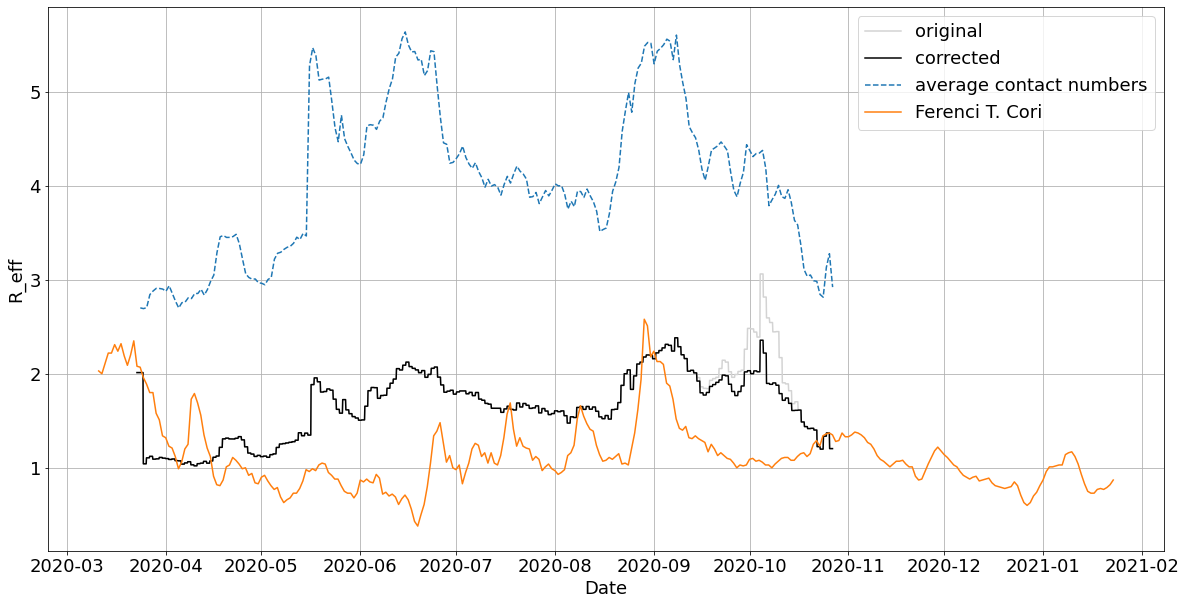

In [19]:
plt.figure(figsize=(20,10))
plt.plot(t1,sim_1.r_eff_plot,label="original",color="lightgrey")
plt.plot(t2,sim_2.r_eff_plot,label="corrected", color="black")
plt.plot(
    [datetime.fromtimestamp(t) for t in sim_1.data.contact_num_data["start"]], 
    sim_1.data.contact_num_data["outside"]+sim_1.data.contact_num_data["family"],
    '--',
    label="average contact numbers")
for m in df["method"].unique()[[1]]:
    sdf = df[df["method"]==m]
    plt.plot(sdf["datetime"],sdf["r0"], label="Ferenci T. "+m)
plt.xlabel("Date")
plt.ylabel("R_eff")
plt.grid()
plt.legend()

In [28]:
# If r_eff_calc is False, then for the kth day (k!=0), there are `bin_size` EQUAL numbers
# r_eff_plot[0] appears once
# E.g. for k=10
k = 10
sim.r_eff_plot[1 + k * sim.bin_size:(k+1) * sim.bin_size]

array([1.08602453, 1.08602453, 1.08602453, 1.08602453, 1.08602453,
       1.08602453, 1.08602453, 1.08602453, 1.08602453])

In [29]:
# For r_eff_calc = False, you can filter for unique values
daily_r_eff = sim.r_eff_plot[::sim.bin_size]
daily_r_eff.shape

(219,)

In [32]:
# Call get_repi_r0_list() to get r_eff values (here is_r_eff_calc is set to False)
# This method fills the member variable repi_r0_list
sim.get_repi_r0_list()
sim.repi_r0_list

-------- Representative matrices --------
Baseline beta: 0.12736156303151233
For matrix BASELINE eig. val = 17.2736573549719 -> baseline r0 = 2.2
-----------------------------------------
For matrix reference eig. val = 57.63074862280115 -> r0 = 7.3399422232761315
For matrix 04_2020 eig. val = 10.283749564221493 -> r0 = 1.3097544183238832
For matrix 05_2020 eig. val = 10.207891616336124 -> r0 = 1.3000930315128394
For matrix 06_2020 eig. val = 11.568319131809496 -> r0 = 1.473359206274605
For matrix 08_2020 eig. val = 12.475132761834743 -> r0 = 1.5888524075729002
For matrix 09_2020 eig. val = 17.012010113814355 -> r0 = 2.1666761984032923
For matrix 10_2020 eig. val = 20.379641518905828 -> r0 = 2.59558299786975
For matrix 11_2020 eig. val = 10.304569611004855 -> r0 = 1.3124060920246012
For matrix 12_2020 eig. val = 13.371338953128284 -> r0 = 1.702994628894564


[7.3399422232761315,
 1.3097544183238832,
 1.3000930315128394,
 1.473359206274605,
 1.473359206274605,
 1.5888524075729002,
 2.1666761984032923,
 2.59558299786975,
 1.3124060920246012,
 1.702994628894564]